### CONFIGURATION

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
import random as rand
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn
import chromosomeDefinition as cd

In [7]:
#VCF
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/ensembleRuleTesting/"
PATH = "/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02010556/"
# BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
#BED_FILE_NAME = "cosmicCancerCensus.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_FULL_FILE = True


# TEMP NA12878 VCF CONFIG
#VCF_SAMPLE = "12878"
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/NA12878vsNA12878/Oct28germline/"
#VCF_FILE_NAME = "GIAB12878vGIAB12878-new3.filtered_variants.vcf"

# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    if patientIDStart < 0:
        patientIDStart = filename.find("DRUP0")
    return filename[patientIDStart:patientIDStart+12]

In [6]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

<h3> LOAD VCF

In [8]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
df = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)

reading vcf file: 170514_HMFregCPCT_FR11442477_FR13256252_CPCT02010556.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 347206


<h3> Truth Check (NA12878 only)

In [ ]:
## TRUTH SET
#SAMPLE_NAMES_TRUTH = {'INTEGRATION':'70-30truth'}
#VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
#VCF_FILE_NAME_TRUTH = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.vcf"
#bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
#dfTruth = aVCF.loadVariantsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH,SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,bed,True)

In [ ]:
#dfTruth.rename(columns={'70-30truthallele':'truth_allele','70-30truthindelDiff':'truth_indelDiff'}, inplace=True)
#dfTruth = dfTruth[['chrom','pos','variantType','ref','truth_allele','truth_indelDiff','bedRegion']]
#dfTruth = dfTruth.set_index(['chrom','pos'])

In [ ]:
#def calculateTruth(df,dfTruth):
#    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
#    df['hasTP'] = False
#    df['hasFP'] = False
#    for columnName in list(df):
#        if columnName.endswith('allele') and not columnName.startswith('truth'):
#            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truth_indelDiff']) \
#                    & (~pd.isnull(df['truth_indelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truth_allele']) \
#                    & (df['variantType'] == 'SNP'))
#            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truth_indelDiff']) \
#                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')& (~pd.isnull(df['truth_allele']))) |((df[columnName] != df['truth_allele']) \
#                    & (df['variantType'] == 'SNP') & (df[columnName] != '')& (~pd.isnull(df['truth_allele'])))
#    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
#    return df

In [ ]:
#df = df.set_index(['chrom','pos'])
#df = calculateTruth(df,dfTruth)

In [ ]:
#dftemp = df.reset_index()
#pd.pivot_table(dftemp[(dftemp.variantType=='INDEL')|(dftemp.variantType=='SNP')], values='pos', index=['bedRegion'], columns=['variantType','Truth'], aggfunc='count')

### LOH variants

In [ ]:
pd.pivot_table(df[(df.normalSGT<>"")&(df.normalSGT<>df.tumorSGT)],\
               values='pos', index=['chromPos','patientName','annGene','normalSGT','tumorSGT'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### HIGH and MODERATE impact NON-missense

In [ ]:
pd.pivot_table(df[((df['annWorstImpact']=='MODERATE')|(df['annWorstImpact']=='HIGH'))&(~df.annAllEffects.str.contains("missense"))&(df.normalSGT=="")],\
               values='pos', index=['chromPos','patientName','annGene','annWorstEffect','annWorstImpact','ref','normalallele'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### Missense

In [ ]:
pd.pivot_table(df[(df.annAllEffects.str.contains("missense"))&(df.normalSGT=="")],\
               values='pos', index=['chromPos','patientName','annGene','normalSGT','tumorSGT'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### SUMMARY OF TYPE

In [ ]:
pd.pivot_table(df[(df['normalSGT']=="0/1")&((df['tumorSGT']=="1/1")|(df['tumorSGT']=="0/1")|(df['tumorSGT']==""))], values='pos', index=['chrom'], columns=['tumorSGT'], aggfunc='count').fillna("")

<h3> Allelic Depth

In [ ]:
max(dftemp.normalAF)

In [ ]:
#Alllele Freq By chromosome
dftemp = df[(df['normalSGT']=="0/1")]
for columnName in list(dftemp):
        if columnName.endswith('AF'):
            ser = dftemp[columnName]
            ser = ser.sort_values()
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency",figsize=[18,10])

In [ ]:
#Alllele Freq By chromosome
dftemp = df[(df['normalSGT']=="0/1")]
chromosomes = dftemp.chrom.unique()
for columnName in list(dftemp):
    for chromosome in chromosomes:
        if columnName.endswith('tumorAF'):
            ser = dftemp[(dftemp.chrom == chromosome)][columnName]
            ser = ser.sort_values()
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=chromosome+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[18,10])

### Heterozygous asymmetry

In [10]:
df['bucketNormalAF']=((df['normalAF'])*50+(rand.random()-0.5)/10000)
df['bucketNormalAF']= df.normalAF.apply(lambda x: 50*x+(rand.random()-0.5)/10000)
df['bucketNormalAF']=df.bucketNormalAF.astype('int')

In [12]:
variantType = "SNP"
total = len(df[(df['variantType']==variantType)&(df['normalSGT']=="0/1")&(df.bedRegion<>"")])
lower = len(df[(df['variantType']==variantType)&(df['normalSGT']=="0/1")&(df['normalAF']<0.5)&(df.bedRegion<>"")])
higher = len(df[(df['variantType']==variantType)&(df['normalSGT']=="0/1")&(df['normalAF']>0.5)&(df.bedRegion<>"")])
print "Total = ",total
print "AF>0.5 = ",higher
print "AF<0.5 = ",lower
print "ref->het FP estimate = ", lower-higher
print "ref->het FP rate = ", round(float(lower - higher) / total,4)

 Total =  200021
AF>0.5 =  92671
AF<0.5 =  92173
ref->het FP estimate =  -498
ref->het FP rate =  -0.0025


In [13]:
df['correctedNormalAF']=df.normalAF.apply(lambda x: x+(rand.random()-0.5)/1000000)

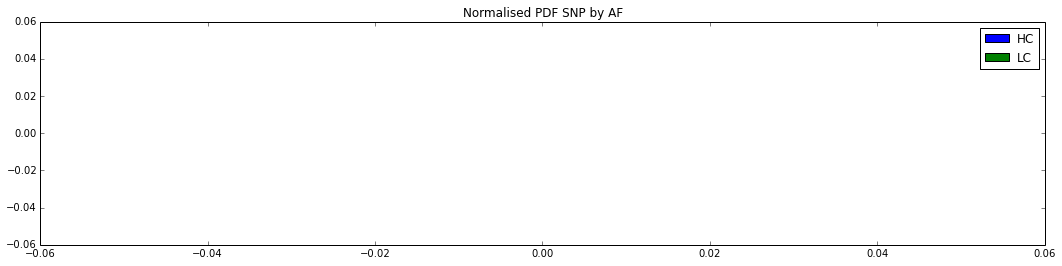

In [17]:
variantType = 'SNP'
plt.figure(figsize=[18,4])
plt.hist([df[(df['variantType']<>variantType)&(df['normalSGT']=="0/1")]['correctedNormalAF'].values,df[(df['variantType']<>variantType)&(df['normalSGT']=="0/1")]['correctedNormalAF'].values],
    cumulative=False, normed=True, bins=50,range=(0.0,1.0),histtype='bar',stacked = False,rwidth=0.8,label=['HC','LC'])
plt.title('Normalised PDF '+variantType+' by AF')
plt.legend()
plt.show()